In [184]:
import mygene
import numpy as np
import pandas as pd
import os
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [183]:
nean_data_dir = "./neanderthal_introgressed/"
allen_data_dir = "./alleninf/alleninf/data/"
donor_data_dir = "./donor_data/"
MNI_brain = "/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz"

CLOBBER = False
MNI_corr = pd.read_csv(os.path.join(allen_data_dir,"corrected_mni_coordinates.csv"),header=0,index_col=0)
# see NOTES.txt for a description of contents, note that CIs may need to be incorporated but the "per_genene"
# file gives us a place to start
nn_CB_per_gene = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_gene.txt"),sep="\t",header=0)
nn_CB_per_snp  = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_snp.txt"),sep="\t",header=0)

out_ensembl2gene = "ase_cerebellum_ensembl2gene.csv"

In [4]:
MNI_corr.head()

,corrected_mni_x,corrected_mni_y,corrected_mni_z
well_id,,,
126439333,-13.467693,2.255686,3.432523
126432538,-53.603259,-8.120055,0.868643
126435762,-16.288739,-34.198856,-19.944686
126439285,-17.820212,3.595613,-32.872868
126435744,-23.726456,-25.139000,-16.692841


In [5]:
nn_CB_per_snp.head()

,chrom,pos,geneid,est.mean,sd.sd,ci0.005,ci0.025,ci0.975,ci0.995,REF,ALT,RSID,ANCESTRAL,GLOBAL_AF,EAS_AF,EUR_AF,est.scaled,est.scaled.polarized
0,1,3551792,ENSG00000116213,-0.117100,0.019119,-0.166485,-0.154656,-0.079607,-0.067841,G,A,rs2296034,G,0.078674,0.1915,0.0388,-0.120094,-0.120094
1,1,10220149,ENSG00000130939,0.559621,0.626792,-0.962172,-0.617283,1.848444,2.294328,T,G,rs77148178,T,0.006190,0.0000,0.0219,1.763459,1.763459
2,1,10221136,ENSG00000130939,-1.386307,0.790525,-3.718340,-3.090941,0.013753,0.390911,G,C,rs114631287,G,0.006190,0.0000,0.0219,-3.652746,-3.652746
3,1,10334544,ENSG00000054523,-0.080021,0.400384,-1.120116,-0.869507,0.702521,0.946659,C,T,rs115415660,C,0.006589,0.0000,0.0229,-0.016892,-0.016892
4,1,10363664,ENSG00000054523,-0.040922,0.043353,-0.153018,-0.126138,0.044048,0.070686,G,T,rs41274458,G,0.006589,0.0000,0.0229,0.091934,0.091934


In [6]:
nn_CB_per_gene.head()

,geneid,est.scaled.polarized.mean
0,ENSG00000000457,0.527106
1,ENSG00000002746,-0.887026
2,ENSG00000003249,-0.594831
3,ENSG00000003987,0.451745
4,ENSG00000004799,0.137427


In [7]:
## extract gene names and additional information about the gene from the ensemble ID
genes = nn_CB_per_gene['geneid'] #these are the ensemble gene ids, called "ensembl.gene" in mygene
fields = "alias,summary,symbol,name,taxid,entrezgene,ensembl.gene"
if not os.path.isfile(out_ensembl2gene) or CLOBBER == True:
    mg = mygene.MyGeneInfo()
    df_genes = mg.querymany(list(genes),species="human",
                            fields=fields,
                            as_dataframe=True,
                            email="christopher.steele@mail.mcgill.ca")
    df_genes.to_csv(out_ensembl2gene)
else:
    df_genes = pd.read_csv(out_ensembl2gene)

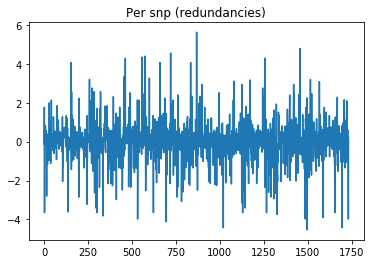

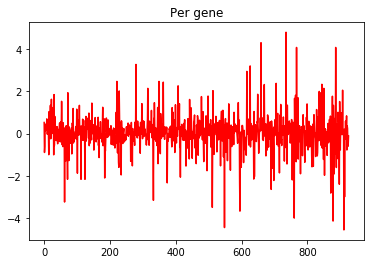

In [8]:
plt.plot(nn_CB_per_snp['est.scaled.polarized'])
plt.title('Per snp (redundancies)')
#plt.bar(np.arange(nn_CB_per_snp.shape[0]),nn_CB_per_snp['est.scaled.polarized'])
plt.figure()
plt.plot(nn_CB_per_gene['est.scaled.polarized.mean'],'r')
plt.title('Per gene')

In [9]:
## merge the df_genes with our neanderthal data
df_gene_nn = pd.merge(df_genes,nn_CB_per_gene,left_on="query",right_on="geneid")


In [111]:
## work with the code that K. Gorgolewski wrote
# reads allen database donor data (whatever is in the dir)
def read_donor_data(data_dir):
    from glob import glob
    donor_ids = [path.split(os.path.sep)[-2] for path in glob(os.path.join(data_dir, "*", "MicroarrayExpression.csv"))]
    print "Data directory contains the following donors: %s" % ", ".join(donor_ids)
    main_df = "empty"
    for donor_id in donor_ids:
        print "Reading data from donor %s"%donor_id
        sample_locations = pd.read_csv(os.path.join(data_dir, donor_id, 'SampleAnnot.csv'))
        df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"]) #column of donor_id
        df_well_ids = sample_locations[['well_id',"slab_type"]] #keep slab type so that we can filter on it
        df = pd.concat([df,df_well_ids],axis=1,ignore_index=False)
        expression_data = pd.read_csv(os.path.join(data_dir, donor_id, 'MicroarrayExpression.csv'),
                                      header=None, index_col=0)
        expression_data.columns = range(expression_data.shape[1])
        df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)
        if isinstance(main_df, str):
            main_df = df
        else:
            main_df = pd.concat([main_df, df], ignore_index=True)
    return main_df #now formatted by row,col sample_well_id,probe_id

In [112]:
#df_donors = read_donor_data(donor_data_dir)


Data directory contains the following donors: H0351.2001
Reading data from donor H0351.2001


In [128]:
#df_donors[df_donors['slab_type']=='CB'].shape

(53, 58695)

Reading donor data was performed on the CIC workstation in the other ipynb file (2017_05_NeanderthalCB_Genes2MNI.v3.ipynb). The data was transferred here, selecting out only the CB slab.

In [130]:
CB_donor_file = "donors_all_slab_type_CB.csv"
df_donor_data_CB = pd.read_csv(os.path.join(donor_data_dir,CB_donor_file),header=0)
print(df_donor_data_CB.shape)
df_donor_data_CB.head()

,Unnamed: 0,donor_id,well_id,slab_type,1058685,1058684,1058683,1058682,1058681,1058680,...,1071202,1071203,1071204,1071205,1071206,1071207,1071208,1071209,1071210,1071211
0,156,H0351.1016,158402984,CB,3.947622,0.674488,0.791284,4.107686,5.491067,8.473847,...,6.454849,7.186370,1.102663,4.426406,10.365387,6.624539,7.147432,1.084218,1.309453,7.024254
1,157,H0351.1016,158402888,CB,3.588285,0.679310,0.777257,4.548565,5.923960,8.472125,...,6.254529,6.877880,3.089069,4.260493,9.958622,6.046748,7.289132,2.561823,1.509929,7.327896
2,158,H0351.1016,158402986,CB,3.075499,1.606844,0.759579,4.360879,5.984050,8.388368,...,5.079211,6.382025,1.780008,4.163607,9.832228,5.686386,7.410866,1.944031,3.481299,7.604971
3,159,H0351.1016,158402970,CB,3.873422,0.674488,0.680751,4.862344,5.935894,8.329800,...,6.528572,7.308408,0.684117,4.254972,9.620506,6.422685,6.755590,2.732050,1.509975,6.286960
4,160,H0351.1016,158402938,CB,3.641216,0.674488,1.476461,4.293067,5.832138,8.195117,...,6.199264,7.327566,2.362821,4.283316,9.693019,6.547512,7.121835,3.215737,1.632292,7.466845


In [135]:
#compress it
df_donor_data_CB.to_hdf(os.path.join(donor_data_dir,CB_donor_file.split(".")[0]+".hdf"),
                        'w',complib="zlib",complevel=6)
(df_donor_data_CB.columns.isin(list('donor_id')))

In [207]:
#identify the genes that overlap between the nn and the donor datasets, include the probe numbers
nn_genes = df_gene_nn.symbol #the raw symbols have extra information in them from the mygene data, strip it
gene2probe = df_probes.gene_symbol 
overlap = gene2probe[gene2probe.isin(nn_genes)] #THIS IS NOT CORRECT XXX

In [334]:
#overlap.to_csv('shit.csv')

In [182]:
nn_genes_list = list(nn_genes)
nn_genes_list_clean = [x for x in nn_genes_list if x != float('nan')]
for name in nn_genes_list_clean:
    print(name),
    print(name.split("-")[0])


 SCYL3 SCYL3
HECW1 HECW1
DBNDD1 DBNDD1
MTMR7 MTMR7
PDK4 PDK4
CIAPIN1 CIAPIN1
TSPOAP1 TSPOAP1
GCFC2 GCFC2
FBXL3 FBXL3
AP2B1 AP2B1
MAP3K9 MAP3K9
ETV1 ETV1
PHTF2 PHTF2
COX10 COX10
CACNA2D2 CACNA2D2
CYTH3 CYTH3
HEATR5B HEATR5B
REV3L REV3L
POMT2 POMT2
SPRTN SPRTN
SCMH1 SCMH1
CLCN6 CLCN6
BTBD7 BTBD7
RNF216 RNF216
PPP5C PPP5C
CEP68 CEP68
LOC101928583 LOC101928583
CLDN11 CLDN11
CNTN1 CNTN1
RNF10 RNF10
RNH1 RNH1
PLEKHO1 PLEKHO1
CCDC28A CCDC28A
BRD9 BRD9
SNX1 SNX1
MYOM2 MYOM2
TLL1 TLL1
RAI14 RAI14
MYO16 MYO16
TRIT1 TRIT1
CUL7 CUL7
WDR37 WDR37
CP CP
FAM120A FAM120A
JKAMP JKAMP
DKK3 DKK3
MSMO1 MSMO1
KIF1B KIF1B
EIF2AK2 EIF2AK2
TRAF3IP2 TRAF3IP2
RIOK2 RIOK2
OGFR OGFR
NCKAP1 NCKAP1
MRPS35 MRPS35
U2AF2 U2AF2
EPN1 EPN1
GPC1 GPC1
TM7SF3 TM7SF3
FAR2 FAR2
OAT OAT
SEC61A2 SEC61A2
FGFR2 FGFR2
MTFR1 MTFR1
POLR1A POLR1A
STON1-GTF2A1L STON1
BCL3 BCL3
ATP1B3 ATP1B3
ZXDC ZXDC
TCOF1 TCOF1
NCK2 NCK2
TFRC TFRC
TRHDE TRHDE
CRMP1 CRMP1
PANX2 PANX2
SELENOO SELENOO
GSDMB GSDMB
KDM5A KDM5A
CA12 CA12
ARHGEF10L ARHGEF10L

AttributeError: 'float' object has no attribute 'split'

In [174]:
nn_genes_list=='Nan'

False

In [127]:
## get the probes - link between probe ID numbers and genes
# probes are the same for ALL donors, same file (checked with diff)
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0,index_col=0) #setting index_col lets us lookup by probe_id
print(df_probes.loc[1058685].gene_symbol)
df_probes.shape

C8G


(58692, 6)

In [101]:
## XXX testing
donor_id = "H0351.2001"
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0) #this has the well_id colum
df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"])
expression_data = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'MicroarrayExpression.csv'), header=None, index_col=0)
expression_data.columns = range(expression_data.shape[1])
df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)

In [102]:
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0)

In [103]:
CB_well_ids = sample_locations[sample_locations['slab_type']=="CB"]['well_id']

In [104]:
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0)


In [333]:
df_probes.head()

,probe_name,gene_id,gene_symbol,gene_name,entrez_id,chromosome
probe_id,,,,,,
1058685,A_23_P20713,729,C8G,"complement component 8, gamma polypeptide",733.0,9
1058684,CUST_15185_PI416261804,731,C9,complement component 9,735.0,5
1058683,A_32_P203917,731,C9,complement component 9,735.0,5
1058682,A_23_P138819,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
1058681,A_24_P232500,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11


In [301]:
## plot the position of the wells on the CB
def mm2vox(aff,pts):
    return (nb.affines.apply_affine(np.linalg.inv(aff),pts)).astype(int)
def vox2mm(aff,pts):
    return nb.affines.apply_affine(aff,pts)

import nibabel as nb
from nilearn import plotting
from nilearn.image import smooth_img
from nilearn.image import math_img

img = nb.load(MNI_brain)
MNI_d = img.get_data()
MNI_aff = img.affine

gene_loc_d = np.zeros_like(MNI_d) #will be filled with points from our wells!
well_ids_CB = df_donor_data_CB.well_id #all of the well IDs in the CB of the allen brain atlas
well2MNI = MNI_corr.loc[well_ids_CB] #mapping of well_ids to xyz (corrected by CG)
well_locs_mm = well2MNI.values
well_locs_mm[:,0] = abs(well_locs_mm[:,0])*-1
well_locs_vox = mm2vox(MNI_aff,well_locs_mm)

In [357]:
a = df_probes.reset_index()
sum(a.gene_symbol=="MAL")

4

In [445]:
MNI_corr.reset_index().head()


,well_id,corrected_mni_x,corrected_mni_y,corrected_mni_z
0,126439333,-13.467693,2.255686,3.432523
1,126432538,-53.603259,-8.120055,0.868643
2,126435762,-16.288739,-34.198856,-19.944686
3,126439285,-17.820212,3.595613,-32.872868
4,126435744,-23.726456,-25.139000,-16.692841


In [384]:
df_donor_data_CB[["well_id",str(1058685)]]
df_donor_data_CB.head()

,Unnamed: 0,donor_id,well_id,slab_type,1058685,1058684,1058683,1058682,1058681,1058680,...,1071202,1071203,1071204,1071205,1071206,1071207,1071208,1071209,1071210,1071211
0,156,H0351.1016,158402984,CB,3.947622,0.674488,0.791284,4.107686,5.491067,8.473847,...,6.454849,7.186370,1.102663,4.426406,10.365387,6.624539,7.147432,1.084218,1.309453,7.024254
1,157,H0351.1016,158402888,CB,3.588285,0.679310,0.777257,4.548565,5.923960,8.472125,...,6.254529,6.877880,3.089069,4.260493,9.958622,6.046748,7.289132,2.561823,1.509929,7.327896
2,158,H0351.1016,158402986,CB,3.075499,1.606844,0.759579,4.360879,5.984050,8.388368,...,5.079211,6.382025,1.780008,4.163607,9.832228,5.686386,7.410866,1.944031,3.481299,7.604971
3,159,H0351.1016,158402970,CB,3.873422,0.674488,0.680751,4.862344,5.935894,8.329800,...,6.528572,7.308408,0.684117,4.254972,9.620506,6.422685,6.755590,2.732050,1.509975,6.286960
4,160,H0351.1016,158402938,CB,3.641216,0.674488,1.476461,4.293067,5.832138,8.195117,...,6.199264,7.327566,2.362821,4.283316,9.693019,6.547512,7.121835,3.215737,1.632292,7.466845


In [549]:
def get_probe_ids(gene_symbols,df_probes2genes_mapping,
                  gene_sybmol_col_name='gene_symbol',
                  probe_col_name='probe_id'):
    #gene2well_mapping are the probes
    df_probes2genes_mapping = df_probes2genes_mapping.reset_index()
    df_probes2genes_mapping = df_probes2genes_mapping.set_index(gene_sybmol_col_name)
    probe_ids = df_probes2genes_mapping.loc[gene_symbols][probe_col_name]
    probe_ids = probe_ids.reset_index()
    return probe_ids

def get_gene_expression(probe_id,df_donor_data,
                        donor_col_name='donor_id',well_col_name='well_id'):
    # pull gene expression across wells for the gene (probe_id) provided
    # returns dataframe with donor_id, well_id, and expression values for this probe
    # only does a single probe_id, so don't try more :-(
    
    # donor_data has columns for each well_id and for each gene probe number
    # probe_ids are numbers, so cast to string to select the column
    if isinstance(probe_id,(int,long)):
        probe_id = str(probe_id)
#    else:
#        probe_id = [str(x) for x in probe_id]
    gene_expression = df_donor_data[[donor_col_name,well_col_name,probe_id]]
    #cols = gene_expression.columns
    #gene_expression.columns = cols[0:2]+'gene_expression'
    gene_expression.rename(columns={probe_id:'expression'},inplace=True)
    return gene_expression

def get_MNI_coords(gene_expression,well2MNI_mapping,well_col_name='well_id'):
    well2MNI_mapping = well2MNI_mapping.reset_index()
    well2MNI_mapping = well2MNI_mapping.set_index(well_col_name)
    MNI_coords = well2MNI_mapping.loc[gene_expression[well_col_name]] #list of coords
    return pd.merge(gene_expression.reset_index(),MNI_coords.reset_index(),
                    left_on=well_col_name,right_on=well_col_name)

def plot_gene_expression(gene_expression_coords,MNI_template,
                         well_col_name='well_id',expression_col_name='expression',
                        flip_coords_to_left_hemisphere=False,gene_symbol="XXX"):
    #flip_coords_to_left_hemisphere to put all datapoints into single hemi in case data is too sparse
    
    import nibabel as nb
    from nilearn import plotting
    from nilearn.image import smooth_img
    from nilearn.image import math_img
    
    #get MNI template
    img = nb.load(MNI_template)
    MNI_d = img.get_data()
    MNI_aff = img.affine
    
    #map voxel coordinates
    gene_loc_d = np.zeros_like(MNI_d) #will be filled with points from our wells!
    #well_locs_mm = gene_expression_coords.values[:,-3:] #xyz at the end - THIS IS NOT A GOOD SOLUTION, FIX ME XXX?
    #if flip_coords_to_left_hemisphere:
    #    well_locs_mm[:,0] = abs(well_locs_mm[:,0])*-1
    #well_locs_vox = mm2vox(MNI_aff,well_locs_mm)
    
    print("number of wells in data: {0}".format(well_locs_vox.shape[0]))
    for index,row in gene_expression_coords.iterrows():
        coord = row.values[-3:] #XXX not the best way to do this :-/
        coord =  mm2vox(MNI_aff,coord) #conver to voxel space for plotting
        gene_loc_d[coord[0],coord[1],coord[2]] = row[expression_col_name]
    
    out_img = nb.Nifti1Image(gene_loc_d,MNI_aff)
    #nb.save(out_img,"allen_well_locations_CB.nii.gz")

    out_img_s = smooth_img(out_img,2)
    #nb.save(out_img_s,"allen_well_locations_CB_s.nii.gz")
    print("Mapping of wells to voxels saved to nii.gz file.")
    plotting.plot_glass_brain(out_img,black_bg=True,display_mode='lyrz',
                              colorbar=True,title="Allen well locations (binary)" + " ["+gene_symbol+"]")
    out_img_s = math_img("img * 100",img = out_img_s)
    plotting.plot_glass_brain(out_img_s,black_bg=True,threshold=0.0001,display_mode='lyrz',
                              colorbar=True,title="Allen well locations (smoothed)")

genes2probes:
  gene_symbol  probe_id
0        NRG1   1030950
1        NRG1   1030949
2        NRG1   1020170
3        NRG1   1020051
4        NRG1   1020049
gene_expression:
     donor_id    well_id  expression
0  H0351.1016  158402984    2.405316
1  H0351.1016  158402888    2.399569
2  H0351.1016  158402986    1.864797
3  H0351.1016  158402970    3.288977
4  H0351.1016  158402938    1.943293
gene_expression_coords:
   index    donor_id    well_id  expression  corrected_mni_x  corrected_mni_y  \
0      0  H0351.1016  158402984    2.405316        -4.719436       -73.748558   
1      1  H0351.1016  158402888    2.399569        -4.234738       -78.369922   
2      2  H0351.1016  158402986    1.864797        -1.321059       -51.375037   
3      3  H0351.1016  158402970    3.288977        -2.202888       -59.130553   
4      4  H0351.1016  158402938    1.943293        -1.567414       -49.748000   

   corrected_mni_z  
0       -39.217050  
1       -40.965201  
2       -31.446562  
3       

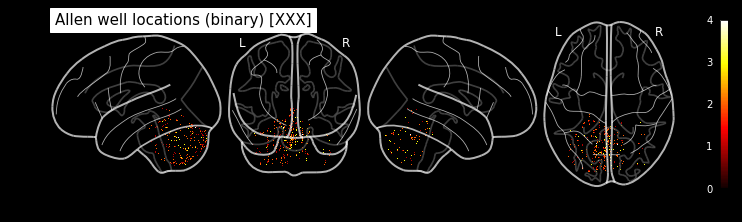

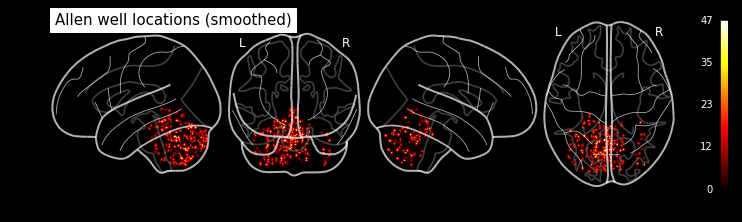

In [552]:
genes2probes = get_probe_ids("NRG1",df_probes)
print("genes2probes:")
print(genes2probes.head())
gene_expression = get_gene_expression(genes2probes.loc[0].probe_id,df_donor_data_CB)
print("gene_expression:")
print(gene_expression.head())
gene_expression_coords = get_MNI_coords(gene_expression,MNI_corr)
print("gene_expression_coords:")
print(gene_expression_coords.head())
plot_gene_expression(gene_expression_coords,MNI_brain)

In [ ]:
for index,row in gene_expression_coords.iterrows():
    print(row.expression)

In [510]:
gene_expression_coords.head().values[:,-4:-1]

array([[6.69330047201, -4.71943591855545, -73.7485582482569],
       [7.2191953498500006, -4.23473755342126, -78.36992227760041],
       [7.03296882516, -1.32105941270081, -51.37503659236871],
       [6.184562048559999, -2.2028881504024502, -59.13055261912189],
       [6.98174552528, -1.5674139883176499, -49.74800024489671]], dtype=object)

In [513]:
print("number of wells in CB: {0}".format(well_locs_vox.shape[0]))
for well in well_locs_vox:
    gene_loc_d[well[0],well[1],well[2]] = 1

out_img = nb.Nifti1Image(gene_loc_d,MNI_aff)
nb.save(out_img,"allen_well_locations_CB.nii.gz")

out_img_s = smooth_img(out_img,3)
nb.save(out_img_s,"allen_well_locations_CB_s.nii.gz")
print("Mapping of wells to voxels saved to nii.gz file.")

number of wells in CB: 368
Mapping of wells to voxels saved to nii.gz file.


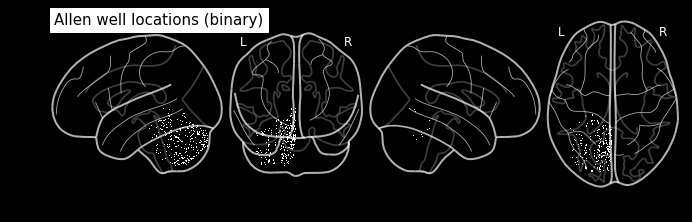

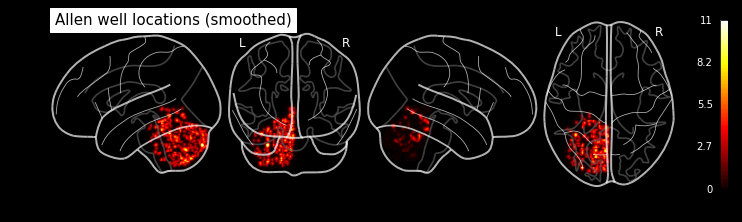

In [514]:
## do the actual plotting of the position of the wells
plotting.plot_glass_brain(out_img,black_bg=True,display_mode='lyrz',title="Allen well locations (binary)")
out_img_s = math_img("img * 100",img = out_img_s)
plotting.plot_glass_brain(out_img_s,black_bg=True,threshold=0.0001,display_mode='lyrz',
                          colorbar=True,title="Allen well locations (smoothed)")